In [1]:
# SAVE 데이터 로드
import os
os.chdir('../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from module.util_main import downsampling, dim_reduct
from collections import defaultdict
font = {'size': 16, 'family':"Malgun Gothic"}
matplotlib.rc('font', **font)

from pathlib import Path

# CER 데이터 로드
# %% load dataset
# start_date = pd.to_datetime('2010-09-01 00:00:00')
# end_date = pd.to_datetime('2009-12-01 23:00:00')

power_df = pd.read_csv('data/CER/power_comb_SME_included.csv')

# 0 to NaN
power_df[power_df==0] = np.nan
power_df['time'] = pd.to_datetime(power_df['time'])
power_df.set_index('time', inplace=True)

# load label
CER_label = pd.read_csv('data/CER/survey_processed_0427.csv')
CER_label['ID'] = CER_label['ID'].astype(str)
CER_label.set_index('ID', inplace=True)

CER = power_df.loc[:,CER_label.index]
del power_df
print('Done load CER')

start_date = pd.to_datetime('2010-01-01 00:00:00')
end_date = pd.to_datetime('2010-06-30 23:30:00')

CER = CER.loc[start_date:end_date,:]

# invalid house processing
nan_ratio = pd.isnull(CER).sum(axis=0) / CER.shape[0]
invalid_idx = (nan_ratio == 1)
CER = CER.loc[:,~invalid_idx]
CER_label = CER_label.loc[~invalid_idx,:]

print(CER.shape)
print(CER_label.shape)


Done load CER
(8688, 3248)
(3248, 15)


In [2]:
def transform(df, sampling_interv = 24 * 2 * 7):
    '''
    [input]
    df: dataframe (timeseries, home)
    
    [output]
    data_2d: 2d array
    home_arr: home index array
    '''

    # dataframe => 3d numpy array
    n_d, n_h = df.shape
    n_w = n_d // sampling_interv
    n_d = n_w * sampling_interv
    df_rs = df.iloc[:n_d,:].values.T.reshape(n_h, -1, sampling_interv)

    # 3d numpy array => 2d numpy array
    n, m, l = df_rs.shape
    data_2d = df_rs.reshape(n*m, l)
    home_arr = np.repeat(np.arange(0, n), m)
    invalid_idx = np.any(pd.isnull(data_2d), axis=1)
    data_2d = data_2d[~invalid_idx, :]
    home_arr = home_arr[~invalid_idx]

    # constant load filtering
    invalid_idx = np.nanmin(data_2d, axis=1) == np.nanmax(data_2d, axis=1)
    data_2d = data_2d[~invalid_idx, :]
    home_arr = home_arr[~invalid_idx]

    return data_2d, home_arr

# 2d daily 형태로 변환 (house * day , hour)
CER_rs, home_arr_c = transform(CER, 24 * 2)


In [3]:
import warnings
warnings.filterwarnings("ignore")

import pickle

with open('clustering_result/kmeans_0530.pickle', 'rb') as handle:
    kmeans_merge = pickle.load(handle)

In [18]:
def extract_rep_load(data, model, home_arr):
    N_Cluster = model.n_clusters

    # 대표부하 extract
    rep_load_for_each_cluster = []
    for n_c in range(N_Cluster):
        clusterig_result = model.predict(data)
        idx2 = clusterig_result == n_c
        rep_load_for_each_cluster.append(data[idx2,:].mean(axis=0))
    rep_cluster, rep_load_list, label_list = [], [], []
    for h in unique_home_arr:
        idx1 = home_arr == h
        v, c= np.unique(clusterig_result[idx1], return_counts=True)
        rep_c = v[np.argmax(c)]
        rep_cluster.append(rep_c)
        label_list.append(label_raw[h])
        rep_load_list.append(rep_load_for_each_cluster[rep_c])

    rep_load_arr = np.array(rep_load_list)
    return rep_load_arr

def calc_MI_corr(data_2d, label, is_categorical = False):
    mi_result = np.zeros((data_2d.shape[1], ))
    corr_result = np.zeros((data_2d.shape[1], ))

    for i in range(data_2d.shape[1]):
        data = data_2d[:,i]

        ## MI
        val, count = np.unique(label, return_counts=True)
        prob = count / count.sum()

        sig_ = np.std(data)
        H_X = 1 / 2 * np.log2(2 * np.pi * np.e * sig_ ** 2)

        H_con = 0
        for ii, v in enumerate(val):
            sig_ = np.std(data[label == v])
            H_con += (1 / 2 * np.log2(2 * np.pi * np.e * sig_ ** 2)) * prob[ii]
        MI = H_X - H_con

        ## corr
        if is_categorical and list(val)!=[0,1]:
            corr_ = 0
            for ii, v in enumerate(val):
                corr_ += np.abs(np.corrcoef(np.ravel(data), np.ravel(label==v))[0,1]) * prob[ii]
        else:
            # print('Not categorical')
            corr_ = np.abs(np.corrcoef(np.ravel(data), np.ravel(label))[0,1])
        corr_result[i] = corr_
        mi_result[i] = MI
    return mi_result, corr_result

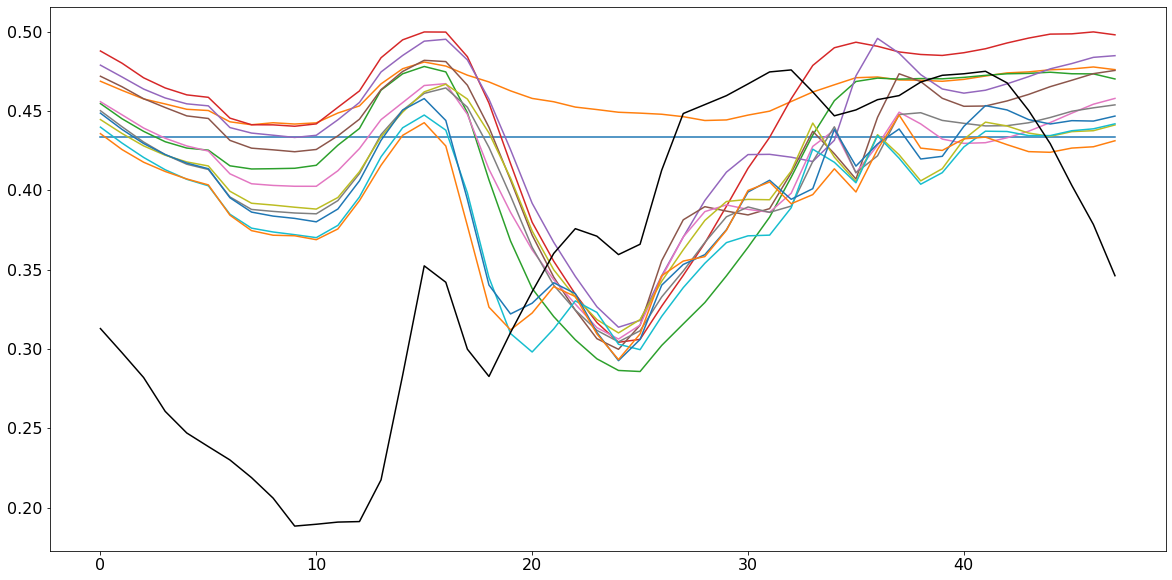

In [21]:
rep_load_dict = dict()

plt.figure(figsize = (20, 10))

data_raw = CER_rs
label_raw = CER_label['Q13'].values
home_arr = home_arr_c

invalid_idx = pd.isnull(label_raw)
# label_raw = label_raw[~invalid_idx]
invalid_home_num = np.where(invalid_idx)[0]
valid_home_idx = np.zeros(home_arr.shape, dtype = bool)
for j in range(home_arr.shape[0]):
    if home_arr[j] in invalid_home_num:
        valid_home_idx[j] = False
    else:
        valid_home_idx[j] = True
data_raw = data_raw[valid_home_idx,:]
home_arr = home_arr[valid_home_idx]
unique_home_arr = np.unique(home_arr)
label = np.array([label_raw[u] for u in unique_home_arr])

data = data_raw.copy()

# for each cluster
for N_Cluster in range(2, 20):
    key = f'CER_all_{N_Cluster}'
    
    if key in kmeans_merge.keys():
        # load model
        model = kmeans_merge[key]
        
        rep_load_arr = extract_rep_load(data, model, home_arr)
        rep_load_dict[key] = rep_load_arr
        
        # correlation 구하기
        mi_, corr_ = calc_MI_corr(rep_load_arr, np.ravel(label))
        plt.plot(corr_, label = key)

### reference - average
rep_cluster, rep_load_list, label_list = [], [], []
for h in unique_home_arr:
    idx1 = home_arr == h
    rep_load_list.append(np.mean(data_raw[idx1,:], axis=0))
    label_list.append(label_raw[h])
rep_load_arr = np.array(rep_load_list)
rep_load_dict['avg'] = rep_load_arr

# correlation 구하기
mi_, corr_ = calc_MI_corr(rep_load_arr, np.ravel(label))
plt.plot(corr_, label = 'avg', color = 'k')
plt.show()


# method 1: daily + weekly

In [29]:
model = kmeans_merge['CER_all_10']
        
clustering_result = model.predict(data)

In [33]:
unique_home_arr = np.unique(home_arr)

for home in unique_home_arr:
    idx = home == home_arr
    print(clustering_result[idx])
    break

[1 3 1 4 1 1 3 1 1 1 1 3 4 1 1 1 1 1 3 1 3 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 4 1 1 1 1 1 1 1 1 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 8 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 1 3 1 1 3 1 1 1 6 1
 1 3 1 1 1 3 1 3 4 1 1 1 1 3 1 1 1 1 1 1 1 1 3 3 4 1 1 1 1 1 4]
